<a href="https://colab.research.google.com/github/arybinski/xai-notebooks/blob/master/Lucid_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Install and Imports

In [0]:
!pip -q install lucid>=0.3.1

import numpy as np
import tensorflow as tf
import lucid.modelzoo.vision_models as models
from lucid.misc.io import show, load, save

# for resizing images
from PIL import Image

# for image uploader
from google.colab import files

# For plots
import matplotlib.pyplot as plt

In [2]:
model = models.InceptionV1()
model.load_graphdef()

W0708 19:48:29.351277 139661635643264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0708 19:48:29.353900 139661635643264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/lucid/misc/io/writing.py:70: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0708 19:48:30.319538 139661635643264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/lucid/misc/io/loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [0]:
def classify2(test_image, n=10, show_output=True):
  tf.reset_default_graph()

  with tf.Session().as_default() as sess:
    input_t = tf.placeholder(tf.float32, shape=(224,224,3))
    model.import_graph(input_t)
    softmax2_t = sess.graph.get_tensor_by_name('import/softmax2:0')
    tf.global_variables_initializer().run()
    logits, = sess.run([softmax2_t], {input_t: test_image})
  
  BATCH = 0
  top_n_label_indices = np.argsort(logits)[BATCH][-n:][::-1]
  safe_top_n_label_indices = np.extract(top_n_label_indices < 1001, top_n_label_indices)
  top_n_labels = np.array(model.labels)[safe_top_n_label_indices]
  top_n_probs = logits[BATCH][safe_top_n_label_indices]
  max_length = max(len(label) for label in top_n_labels)
  predictions = ["{}: {: >6.2%}".format(label.rjust(max_length), prob) for (label, prob) in zip(top_n_labels, top_n_probs)]
  
  if show_output:
    show(test_image)
    print("\n".join(predictions))
  
  return top_n_probs

In [0]:
# Takes two images and composites them
def composite_img(background_img, patch_img, patch_width_ratio=0.1, patch_position=(0.0, 0.0)):
  composite = background_img.copy()
  composite_img = Image.fromarray(np.uint8(composite * 255.))
  composite_img = composite_img.resize((224, 224), Image.LANCZOS)
  composite = (np.asarray(composite_img)/255.)[:,:,:3]

  if patch_width_ratio > 0: 
    patch_img_width = int(patch_width_ratio * 224)
    patch_img_ = Image.fromarray(np.uint8(patch_img[:,:,:3] * 255.))
    patch_img_thumb = patch_img_.resize((patch_img_width, patch_img_width), Image.LANCZOS)
    patch_img_thumb_array = np.asarray(patch_img_thumb)/255.
    patch_img_thumb_size = patch_img_thumb_array.shape

    patch_y = int(patch_position[1] * (224 - patch_img_thumb_size[1]))
    patch_x = int(patch_position[0] * (224 - patch_img_thumb_size[0]))

    
    composite[patch_y:patch_y + patch_img_thumb_size[1], patch_x:patch_x + patch_img_thumb_size[0], 0:3] = patch_img_thumb_array
    
  composite_img = Image.fromarray(np.uint8(composite * 255.))
  composite_img_resize = composite_img.resize((224, 224), Image.LANCZOS)
  composite_img_resize_array = np.asarray(composite_img_resize)/255.
  return composite_img_resize_array

In [0]:
snorkel_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/snorkel.png"
grey_whale_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/grey-whale.jpg"
frying_pan_url = "https://storage.googleapis.com/lucid-static/activation-atlas/adversarial-examples/examples/frying-pan.png"

W0708 19:50:50.443931 139661635643264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/lucid/modelzoo/vision_base.py:136: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 19:50:50.454635 139661635643264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/lucid/modelzoo/util.py:53: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



(224, 224, 3)



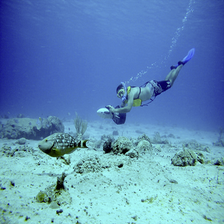

           snorkel: 55.60%
        coral reef: 18.65%
       scuba diver: 13.49%
        loggerhead:  5.52%
          lionfish:  1.71%
         sea snake:  1.36%
               ski:  0.43%
         rock crab:  0.40%
       rock beauty:  0.39%
leatherback turtle:  0.29%


array([0.5560084 , 0.1865294 , 0.13486609, 0.05519044, 0.01708108,
       0.01356929, 0.00431692, 0.00403554, 0.00388307, 0.00291969],
      dtype=float32)

In [8]:
snorkel_img = load(snorkel_url)
im = Image.fromarray(np.uint8(snorkel_img * 255.));
im_resize = im.resize((224, 224), Image.LANCZOS)
im_array = np.asarray(im_resize)/255.
test_image = im_array[:,:,:3]
print(test_image.shape)
classify2(test_image)

In [9]:
%load_ext autoreload
%autoreload 2
!pip install -q lime
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

     |████████████████████████████████| 276kB 2.8MB/s 


In [0]:
explainer = lime_image.LimeImageExplainer()

In [11]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_image, classify2, top_labels=5, hide_color=0, num_samples=1000)

ValueError: ignored